In [1]:
import os
from collections import defaultdict

from config import DATASET_DIR, DATASET_PATH
from reader import Reader

First, I check whether there are non-matching files in the `dataset/` directory

In [2]:
dataset = DATASET_DIR / "dataset"
bmp_files, xml_files = [f for f in os.listdir(dataset) if f.endswith(".bmp")], [f for f in os.listdir(dataset) if f.endswith(".xml")]
bmp_basenames, xml_basenames = {os.path.splitext(f)[0] for f in bmp_files}, {os.path.splitext(f)[0] for f in xml_files}

only_bmp = bmp_basenames - xml_basenames
only_xml = xml_basenames - bmp_basenames
both = bmp_basenames & xml_basenames

print("BMP only  :", len(only_bmp))
print("XML only  :", len(only_xml))
print("Matched   :", len(both))



BMP only  : 0
XML only  : 0
Matched   : 8325


Great, we have all matching image and ground truth files. Now I will check the two `.csv` files provided with the data.

In [3]:
import pandas as pd

train_df, test_df = pd.read_csv(DATASET_DIR / "train_labels.csv"), pd.read_csv(DATASET_DIR / "test_labels.csv")

print(train_df.columns)
train_df.head()

Index(['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax'], dtype='object')


filename  width  height     class  xmin  ymin  xmax  ymax
0  14_024_2_0042.bmp    800     800  Stenosis   235   156   282   192
1  14_031_4_0031.bmp    800     800  Stenosis   419   319   446   349
2  14_046_5_0066.bmp   1000    1000  Stenosis   679   307   699   336
3  14_010_6_0035.bmp    512     512  Stenosis    94   244   126   286
4  14_014_1_0015.bmp    512     512  Stenosis   163   118   203   151

In [4]:
bboxes_per_image = train_df.groupby("filename").size().reset_index(name='count')
print(bboxes_per_image['count'].unique())
print(bboxes_per_image['count'].value_counts())
bboxes_per_image

[1 2]
count
1    7491
2       1
Name: count, dtype: int64


filename  count
0     14_002_5_0016.bmp      1
1     14_002_5_0017.bmp      2
2     14_002_5_0020.bmp      1
3     14_002_5_0021.bmp      1
4     14_002_5_0022.bmp      1
...                 ...    ...
7487  14_099_8_0007.bmp      1
7488  14_099_8_0008.bmp      1
7489  14_099_8_0009.bmp      1
7490  14_099_8_0011.bmp      1
7491  14_099_8_0012.bmp      1

[7492 rows x 2 columns]

This shows that there is a case (first patient, first video, second frame) includes two bounding boxes for stenosis. This is strange since visual inspection of the pictures show that the before and after frames of `14_002_0017.bmp` show only one bounding box. The following includes the description of bounding box stats:

In [5]:
bboxes_per_image.describe()

count
count  7492.000000
mean      1.000133
std       0.011553
min       1.000000
25%       1.000000
50%       1.000000
75%       1.000000
max       2.000000

The following code is used to see whether there are multiple views of the stenosis for the same patient. The filenames in the `dataset/` directory are structured as follows:
`14_PatientId_VideoId_FrameNr`

In [6]:
import re
pattern = re.compile(r"^14_(\d+)_(\d+)_(\d+)$")
rows = []

for base_name in both:
    m = pattern.match(base_name)
    if m:
        patient_id, video_id, frame_nr = int(m.group(1)), int(m.group(2)), int(m.group(3))
        rows.append((patient_id, video_id, frame_nr))

df_pv = pd.DataFrame(rows, columns=['patient_id', 'video_id', 'frame_nr'])

df_pv.sort_values(by=["patient_id","video_id","frame_nr"], inplace=True)

df_grouped_patient = df_pv.groupby("patient_id")

for pid, group in df_grouped_patient:
    n_videos     = group["video_id"].nunique()
    total_frames = len(group)
    print(f"Patient {pid} has {n_videos} video(s), with {total_frames} total frames.")
    
    # Within each patient group, break down frames by each video
    video_groups = group.groupby("video_id")
    for vid, vgroup in video_groups:
        frames_count = len(vgroup)
        print(f"  - Video {vid}: {frames_count} frame(s)")

    print("----------------------------------------------------")


Patient 2 has 2 video(s), with 53 total frames.
  - Video 5: 33 frame(s)
  - Video 8: 20 frame(s)
----------------------------------------------------
Patient 3 has 2 video(s), with 44 total frames.
  - Video 1: 27 frame(s)
  - Video 2: 17 frame(s)
----------------------------------------------------
Patient 6 has 1 video(s), with 113 total frames.
  - Video 1: 113 frame(s)
----------------------------------------------------
Patient 7 has 5 video(s), with 374 total frames.
  - Video 3: 67 frame(s)
  - Video 5: 88 frame(s)
  - Video 6: 67 frame(s)
  - Video 8: 89 frame(s)
  - Video 10: 63 frame(s)
----------------------------------------------------
Patient 10 has 2 video(s), with 82 total frames.
  - Video 1: 50 frame(s)
  - Video 6: 32 frame(s)
----------------------------------------------------
Patient 12 has 2 video(s), with 36 total frames.
  - Video 3: 13 frame(s)
  - Video 4: 23 frame(s)
----------------------------------------------------
Patient 14 has 1 video(s), with 23 tot

Further, I will follow with some visualizations in order to see whether these are really different videos from different angles or the same, i.e., multi-view vs. single-view


In [1]:
from reader import Reader
r = Reader()

[16:29:49][reader.Reader._merge_labels] "Merged dataset found at C:\Users\Ata\Desktop\BEP\Code\data\stenosis_detection\labels.csv. Loading merged dataset"
[16:29:49][reader.Reader._load_dataset] "Building XCA images from CSV files"


In [3]:
from visualize import show_xca_image

def find_patient_with_most_views(reader):
    from collections import defaultdict
    
    patient_videos = defaultdict(set)
    
    for img in reader.xca_images:
        patient_videos[img.patient_id].add(img.video_id)
    
    max_videos, max_video_patient = 0, None
    
    for pid, vids in patient_videos.items():
        if len(vids) > max_videos:
            max_videos, best_patient = len(vids), pid
    
    return best_patient, max_videos

pid, vid_count = find_patient_with_most_views(r)
print(f"Patient {pid} has the most videos: {vid_count}")




Patient 21 has the most videos: 15


In [4]:
test_patient = 2
patient_videos = r.get(patient_id=test_patient, return_videos=True)

grouped_videos = dict()
for vid in patient_videos:
    if vid.video_id not in grouped_videos:
        grouped_videos[vid.video_id] = [vid]
    else:
        grouped_videos[vid.video_id].append(vid)

grouped_videos = sorted(grouped_videos.keys())
grouped_videos

[5, 8]

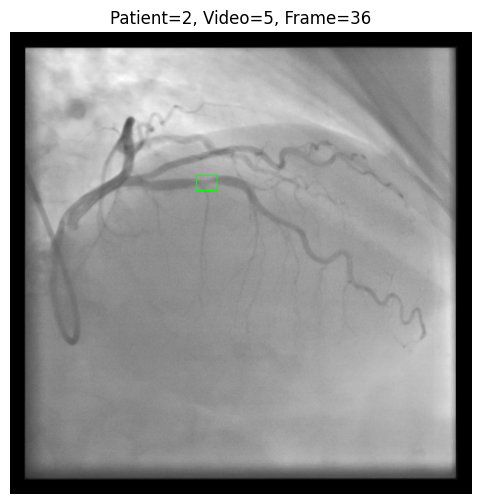

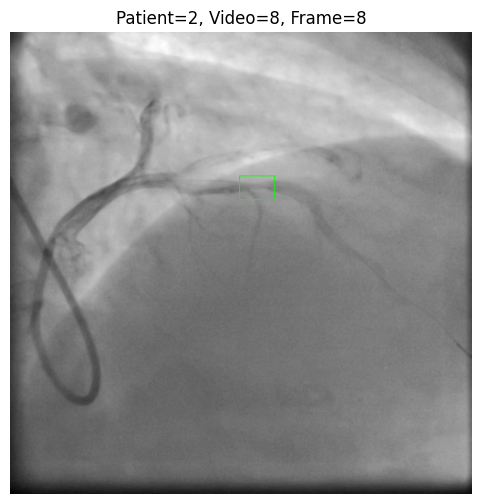

In [5]:
for vid in grouped_videos:
    img = r.get(patient_id=test_patient, video_id=vid)  # random frame
    show_xca_image(img)
    

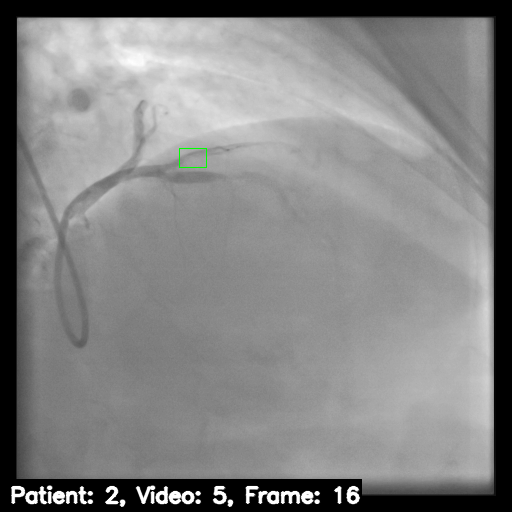

In [8]:
from IPython.display import Image, display
from visualize import image_to_gif

# example
p2_v5 = r.get(patient_id=2, video_id=5, return_frames=True)
file = image_to_gif(p2_v5, output_path='p2_v2.gif', fps=5)
display(Image(file))

